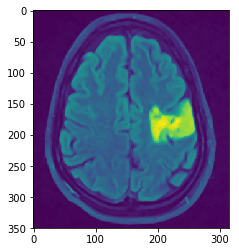

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage import measure

#read image
image = cv2.imread('H:/FYP/Brain_Tumor_Dataset/yes/Y50.jpg',0)
#image2 = image.copy()

#preprocess using median blur
img = cv2.medianBlur(image,5)

plt.imshow(img)

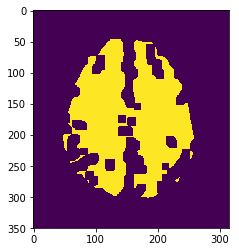

In [21]:
#erosion using morphological operations

ret,th1 = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(th1, kernel, iterations = 5)
plt.imshow(erosion)

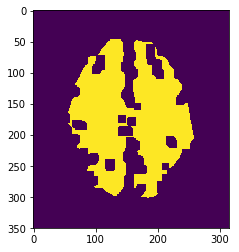

In [22]:
# perform a connected component analysis on the eroded image, then initialize a mask to store only the "large" components

foreground_value = 255
mask = np.uint8(erosion == foreground_value)
labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1+np.argmax(stats[1:, cv2.CC_STAT_AREA]) 
mask1 = np.zeros_like(erosion)
mask1[labels == largest_label] = foreground_value

fig, ax = plt.subplots(nrows=1, ncols=1,  figsize = (4, 4))
plt.imshow(mask1)

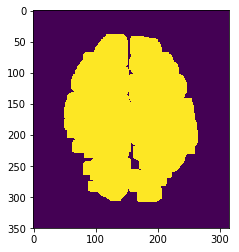

In [23]:
mask = cv2.dilate(mask1,kernel,iterations = 7)
plt.imshow(mask)

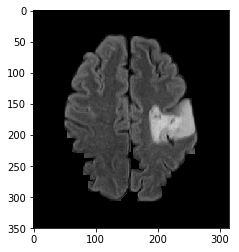

In [24]:
#extract the brain using the mask
img = io.imread("H:/FYP/Brain_Tumor_Dataset/yes/Y50.jpg")

mask2 = np.where((mask<200),0,1).astype('uint8')

brain_img = img*mask2[:,:,np.newaxis]

# brain_img = img*mask2[:,:]

plt.imshow(brain_img)

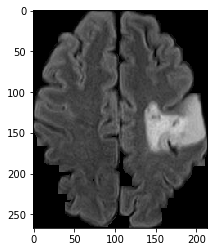

In [25]:
# Load image, grayscale, Otsu's threshold, and extract ROI
image = brain_img
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
x,y,w,h = cv2.boundingRect(thresh)
ROI = image[y:y+h, x:x+w]
plt.imshow(ROI)

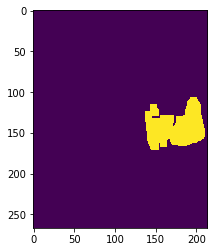

In [26]:
# Color segmentation on ROI
hsv = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)
lower = np.array([0, 0, 125])
upper = np.array([179, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
plt.imshow(mask)

mask = cv2.erode(mask, kernel, iterations = 4)
plt.imshow(mask)

mask = cv2.dilate(mask,kernel,iterations = 4)
plt.imshow(mask)

In [27]:
# Crop left and right half of mask
x, y, w, h = 0, 0, ROI.shape[1]//2, ROI.shape[0]
left = mask[y:y+h, x:x+w]
right = mask[y:y+h, x+w:x+w+w]

total_pixels = cv2.countNonZero(mask)

# Count pixels
left_pixels = cv2.countNonZero(left)
right_pixels = cv2.countNonZero(right)

# Crop top and bottom half of mask
x, y, w, h = 0, 0, ROI.shape[1], ROI.shape[0]//2
bottom = mask[y+h:y+h+h, x:x+w]
top = mask[y:y+h, x:x+w]

# Count pixels
top_pixels = cv2.countNonZero(top)
bottom_pixels = cv2.countNonZero(bottom)

Percentage of area of the tumor in each segment:
Left: 0.0 %
Right: 100.0 %
Top: 26.142716211772445 %
Bottom: 73.85728378822756 %
distance =  66.61080993352356
tumor location:( 61.6822429906542 , -6.36704119850188 )
bottom right


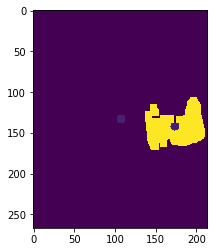

In [28]:
# convert the grayscale image to binary image
ret,thresh = cv2.threshold(mask,127,255,0)
 
# calculate moments of binary image
M = cv2.moments(thresh)
 
# calculate x,y coordinate of center of tumor
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# calculate x,y coordinate of center of image
iX = ROI.shape[1]//2
iY = ROI.shape[0]//2

# put text and highlight the center
tumor_img = cv2.circle(mask, (cX, cY), 5, (22, 100, 8), -1)
#center = cv2.putText(center, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (22, 100, 8), 2)
 
tumor_img = cv2.circle(tumor_img, (iX, iY), 5, (22, 100, 8), -1)
#center = cv2.putText(center, "centroid", (iX - 25, iY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (22, 100, 8), 2)
 
import math
p1 = [iX, iY]
p2 = [cX, cY]
distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )

# display the image
plt.imshow(tumor_img)

print("Percentage of area of the tumor in each segment:")
print('Left:', (left_pixels/total_pixels)*100, '%')
print('Right:', (right_pixels/total_pixels)*100, '%')
print('Top:', (top_pixels/total_pixels)*100, '%')
print('Bottom:', (bottom_pixels/total_pixels)*100, '%')

print('distance = ', distance)

x_len = ROI.shape[1]
y_len = ROI.shape[0]

rX = cX
rY = y_len - cY

kX = ((rX/x_len)*200) - 100
kY = ((rY/y_len)*200) - 100
print('tumor location:(',kX,',' ,kY, ')')

if left_pixels > right_pixels:
    if top_pixels > bottom_pixels:
        location = "top left"
    else:
        location = "bottom left"
else:
    if top_pixels > bottom_pixels:
        location = "top right"
    else:
        location = "bottom right"
        
print(location)

In [29]:
image_plane = "axial"

if image_plane == "axial":
    if location == "top left":
        print("Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma")
    elif location == "top right":
        print("Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma")
    elif location == "bottom left":
        print("Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma, pineocytoma")
    elif location == "bottom right":
        print("Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma, pineocytoma")
        
if image_plane == "sagittal":
    if location == "top left":
        print("Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma")
    elif location == "top right":
        print("Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma, Meningioma, ependymoma, central neurocytoma, subependymoma")
    elif location == "bottom left":
        print("Colloid cyst, astrocytoma, chordoid glioma")
    elif location == "bottom right":
        print("Schwannoma, meningioma, epidermoid, Hemangioblastoma, astrocytoma, Subependymoma, choroid plexus papilloma, ependymoma, Meningioma, ependymoma, central neurocytoma, subependymoma, Colloid cyst, astrocytoma, chordoid glioma")
        
if image_plane == "coronal":
    if location == "top left":
        print("Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma, Meningioma, ependymoma, central neurocytoma, subependymoma")
    elif location == "top right":
        print("Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma, Meningioma, ependymoma, central neurocytoma, subependymoma")
    elif location == "bottom left":
        print("Schwannoma, meningioma, epidermoid, Hemangioblastoma, astrocytoma, Subependymoma, choroid plexus papilloma, ependymoma, Meningioma, ependymoma, central neurocytoma, subependymoma")
    elif location == "bottom right":
        print("Schwannoma, meningioma, epidermoid, Hemangioblastoma, astrocytoma, Subependymoma, choroid plexus papilloma, ependymoma, Meningioma, ependymoma, central neurocytoma, subependymoma")

Meningioma, hemangioendothelioma, hemangioperycitoma, Pleomorphic xanthoastrocytoma, Oligodendroglioma and fibrillary/anaplastic astrocytoma, Glioblastoma, lymphoma, pineocytoma


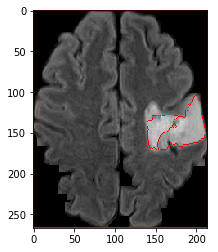

In [30]:
# Dispalying detected tumor in the original MRI

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(tumor_img,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
et, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(ROI,markers)
ROI[markers == -1] = [255,0,0]

plt.imshow(markers)
plt.imshow(ROI)
